In [3]:
import artm
%matplotlib inline
import glob
import os, re
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from nltk.corpus import stopwords
import numpy as np
from pymorphy2 import MorphAnalyzer
import gensim
import pickle
morph = MorphAnalyzer()
from nltk.tokenize import word_tokenize

## Домашнее задание

Основаная задача - **построить хорошую тематическую модель с интерпретируемыми топиками**.

1) сделайте нормализацию (если pymorphy2 работает долго используйте mystem или попробуйте установить быструю версию - `pip install pymorphy2[fast]`, можно использовать какой-то другой токенизатор) 

2) добавьте нграммы (в тетрадке есть закомменченая ячейка с Phrases); 

3) сохраните тексты .vw формате;

4) сделайте хороший словарь (отфильтруйте слишком частотные и редкие слова, попробуйте удалить стоп-слова, сохраните словарь и посмотрите на него, вдруг что-то плохое сразу будет заметно); 

5) постройте несколько ARTM моделей (переберите количество тем, поменяйте значения tau у регуляризаторов), если получаются плохие темы, поработайте дополнительно над предобработкой и словарем; 

6) для самой хорошей модели в отдельной ячейке напечатайте 3 хороших (на ваш вкус) темы

7) в другой ячейки нарисуйте график обучения этой модели 

8) в третьей ячейки опишите какие параметры (количество тем, регуляризаторы, их tau) вы использовали и как обучали (например, после скольки проходов добавили регуляризатор разрежнивания тем (Phi), добавляли ли разреженность документам (Theta) и когда, как повышали значения, сколько итерации модель продожала улучшаться (снижалась перплексия, росли другие метрики);

Сохраните тетрадку с экспериментами и положите её на гитхаб, ссылку на неё укажите в форме.

**Оцениваться будут главным образом пункты 6, 7 и 8. (3, 1, 4 баллов соответственно). Чтобы заработать остальные 2 балла, нужно хотя бы немного изменить мой код на промежуточных этапах (добавить что-то, указать другие параметры и т.д). **

Предобработаем и загрузим тексты так же, как в предыдущей части. Исследовать модель будем на н-граммах.

In [2]:
def remove_tags(text):
    return re.sub(r'<[^>]+>', '', text)

def clean(words):
    clean = [morph.parse(word)[0].normal_form for word in words if word.isalnum()]
    return clean

In [22]:
habr_texts = [clean(word_tokenize(remove_tags(text.lower()))) for text in open('habr_texts.txt', encoding='utf-8')]

In [4]:
'''with open('lemmatized_texts_artm.txt', 'wb') as f:
    pickle.dump(habr_texts, f)'''
f=open('lemmatized_texts_artm.txt', 'rb') 
lem_texts=f.read()
habr_texts=pickle.loads(lem_texts)

In [5]:
ph = gensim.models.Phrases(habr_texts, scoring='npmi', threshold=0.3, common_terms=set(stopwords.words('russian')))
p = gensim.models.phrases.Phraser(ph)
ngrammed_habr_texts = p[habr_texts]

In [6]:
f = open('ngrammed_habr_texts.vw', 'w', encoding='utf-8')

for i, text in enumerate(ngrammed_habr_texts):
    c = Counter(text)
    doc = 'doc_'+ str(i) + ' '
    vw_text = ' '.join([x+':'+str(c[x]) for x in c])
    f.write(doc + vw_text  + '\n')
f.close()

In [7]:
def print_measures(model_artm):
    print('Sparsity Phi: {0:.3f} ARTM)'.format(
        model_artm.score_tracker['SparsityPhiScore'].last_value)
)
    print('Sparsity Theta: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['SparsityThetaScore'].last_value))

    print('Kernel contrast: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['TopicKernelScore'].last_average_contrast))

    print('Kernel purity: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['TopicKernelScore'].last_average_purity))

    print('Perplexity: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['PerplexityScore'].last_value)
)
    plt.plot(range(model_artm.num_phi_updates), model_artm.score_tracker['PerplexityScore'].value, 'r--', linewidth=2)
    plt.xlabel('Iterations count')
    plt.ylabel(' ARTM perp. (red)')
    plt.grid(True)
    plt.show()

In [8]:
batch_vectorizer = artm.BatchVectorizer(data_path='ngrammed_habr_texts.vw'
                                        , data_format='vowpal_wabbit'
                                        , target_folder='ngram_batches'
                                        , batch_size=1000) 

In [9]:
batch_vectorizer = artm.BatchVectorizer(data_path='ngram_batches', data_format='batches') 

In [10]:
dictionary = artm.Dictionary()

In [11]:
dictionary.gather(data_path='batches')
dictionary.filter(class_id='@default_class', min_df=10, max_df=2000)

In [12]:
dictionary.save_text('dict1_ngrams.txt')
# dictionary = artm.Dictionary()
# dictionary.load_text('dict.txt')

Построим ARTM-модель:

In [39]:
model_artm = artm.ARTM(topic_names=['topic_{}'.format(i) for i in range(200)],
                       
                       regularizers=[
                           artm.DecorrelatorPhiRegularizer(
                                            name='Decorr', tau=0.3, 
                                            class_ids=['@default_class'],
                                            topic_names=['topic_{}'.format(i) for i in range(0, 200)]),
                           
                           artm.SmoothSparsePhiRegularizer(
                                            name='SmoothPhi_1', 
                                            class_ids=['@default_class'],
                                            tau=0.2, 
                                            topic_names=['topic_{}'.format(i) for i in range(0, 200)])
                                    ]
                        )


In [40]:
model_artm.initialize(dictionary=dictionary)

In [41]:
model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore', dictionary=dictionary), overwrite=True)
model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'), overwrite=True)
model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'), overwrite=True) 
model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.1), overwrite=True) 
model_artm.scores.add(artm.TopTokensScore(class_id='@default_class', name='TopTokensScore_1', num_tokens=10), overwrite=True)

In [49]:
model_artm.num_document_passes = 3
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=4)

Sparsity Phi: 0.855 ARTM)
Sparsity Theta: 0.298 (ARTM)
Kernel contrast: 0.305 (ARTM)
Kernel purity: 0.239 (ARTM)
Perplexity: 465.723 (ARTM)


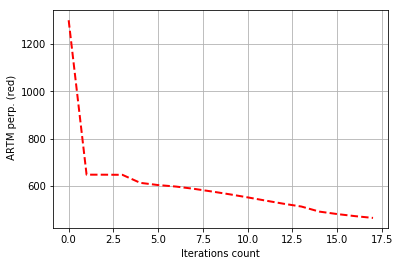

In [50]:
print_measures(model_artm)

In [52]:
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.15, 
                                                            topic_names=['topic_{}'.format(i) for i in range(1, 200)],
                                                            ), overwrite=True)
model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.15, 
                                                              topic_names=['topic_{}'.format(i) for i in range(1, 200)]), overwrite=True)

In [53]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer,num_collection_passes=1)

In [54]:
phi_tau = model_artm.regularizers['SparsePhi'].tau
theta_tau = model_artm.regularizers['SparseTheta'].tau

for i in range(10):
    model_artm.regularizers['SparsePhi'].tau = (phi_tau + (phi_tau*0.5))
    model_artm.regularizers['SparseTheta'].tau = (theta_tau + (theta_tau*0.1))
    
    model_artm.fit_offline(batch_vectorizer=batch_vectorizer,num_collection_passes=1)   

Sparsity Phi: 0.923 ARTM)
Sparsity Theta: 0.468 (ARTM)
Kernel contrast: 0.334 (ARTM)
Kernel purity: 0.491 (ARTM)
Perplexity: 424.521 (ARTM)


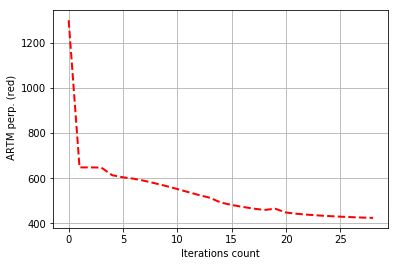

In [55]:
print_measures(model_artm)

## Результаты сравнения разных моделей:  

Первоначальные параметры, 100 текстов: конечная перплексия несколько выше (524 против 520 на 200 текстах)  
200 текстов, tau регуляторов в самом начале повышены на 0.05: конечная перплексия ниже (513)  
200 текстов, tau регуляторов в самом начале повышены на 0.05, количество проходов по документам и по всей коллекции увеличено на 1: конечная перплексия существенно ниже (424), на графиках представлена именно эта модель.  

Примеры хороших тем: 1 (компьютерная безопасность), 2 (образование) и 3 (распределение финансов в регионах).

In [56]:
for topic_name in model_artm.topic_names[:50]:
    print(topic_name + ': ')
    try:
        for x in model_artm.score_tracker['TopTokensScore_1'].last_tokens[topic_name]:
            print(x)
        print('---------')
    
    except KeyError:
        continue

topic_0: 
насос
микроскоп
science
nmap
пропускать
репортёр
fedora
стакан
щётка
погибнуть
---------
topic_1: 
атака
защита
ноутбук
злоумышленник
intel
угроза
взлом
жертва
хакер
вредоносный
---------
topic_2: 
курс
обучение
студент
лекция
школа
университет
знание
учиться
изучать
занятие
---------
topic_3: 
показатель
регион
план
причина
результат
бюджет
оценка
исполнитель
период
оценить
---------
topic_4: 
причём
впрочем
хотя
железо
целое
весьма
общий
вполне
разумеется
однако
---------
topic_5: 
материал
производство
регистратор
аппарат
качество
изделие
применение
сканер
сканирование
производитель
---------
topic_6: 
дизайн
любой
трансляция
впечатление
приятный
хотеть
дизайнер
создать
удобный
друг
---------
topic_7: 
сервер
сервис
блокировка
ресурс
серверный
нагрузка
мониторинг
отдельный
получать
через
---------
topic_8: 
gt
lt
return
data
1
key
type
value
if
true
---------
topic_9: 
программа
тогда
однако
название
ассемблер
идея
провести
современный
написание
набор
---------
topic_10: 
